<a href="https://colab.research.google.com/github/EduHdzVillasana/COVIDSTATSMX/blob/master/An%C3%A1lisis%20y%20Modelado/Modelo_Predictorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación de modelo para predecir probabilidad de muerte por COVID-19
En este notebook se creará un modelo de regresión logística para predecir la probabilidad de muerte de un paciente positivo a sars-cov-2 dadas sus condiciones.

También se creará un modelo para predecir la probabilidad de contraer enfermedad grave dadas sus condiciones y así identificar personas vulnerables.

## Librerías a utilizar


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Librerias para la regresión logística
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from tabulate import tabulate
from sklearn import linear_model
from sklearn import preprocessing

# Librerias para la validación del modelo
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
mainpath = "/content/drive/MyDrive/Datos Abiertos"
filepath = "210401COVID19MEXICO_filtered.csv"

data = pd.read_csv(os.path.join(mainpath, filepath), index_col=0)
data.sample(3);

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
columns = ['EDAD', 'EMBARAZO','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'TIEMPO_ESPERA', 'HOSPITALIZADO','SEXO_','SECTOR_ATENDIDO','ESTADO','ENFERMEDAD_GRAVE','FALLECIDO']
data = data[columns]

## Preparación de datos

In [4]:
data = data.rename({"SEXO_":"SEXO"}, axis = 1)

In [5]:
data.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO', 'SEXO',
       'SECTOR_ATENDIDO', 'ESTADO', 'ENFERMEDAD_GRAVE', 'FALLECIDO'],
      dtype='object')

### Creación de variables dummies (catagóricas)

In [6]:
categories = ["SEXO","SECTOR_ATENDIDO","ESTADO"]
for cat in categories:
  cat_dummies = pd.get_dummies(data[cat], prefix = cat)
  data = data.join(cat_dummies)

In [7]:
data.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO', 'SEXO',
       'SECTOR_ATENDIDO', 'ESTADO', 'ENFERMEDAD_GRAVE', 'FALLECIDO',
       'SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL',
       'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL',
       'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR',
       'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'E

In [8]:
# Columnas de las condiciones del paciente ántes de ser atendido por una institución de salud
before_columns = ['EDAD', 'EMBARAZO','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'ESTADO_AS','SEXO_HOMBRE', 'SEXO_MUJER',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'ESTADO_PL',
       'ESTADO_QR', 'ESTADO_QT', 'ESTADO_SL', 'ESTADO_SP', 'ESTADO_SR',
       'ESTADO_TC', 'ESTADO_TL', 'ESTADO_TS', 'ESTADO_VZ', 'ESTADO_YN',
       'ESTADO_ZS']

# Columnas de las condiciones del paciente después de ser atendido por una institución de salud
after_columns = ['EDAD', 'EMBARAZO','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'TIEMPO_ESPERA', 'HOSPITALIZADO','SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL', 'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL', 'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR', 'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'ESTADO_PL',
       'ESTADO_QR', 'ESTADO_QT', 'ESTADO_SL', 'ESTADO_SP', 'ESTADO_SR',
       'ESTADO_TC', 'ESTADO_TL', 'ESTADO_TS', 'ESTADO_VZ', 'ESTADO_YN',
       'ESTADO_ZS']



### Eliminación de outlier
Se identificó que una columna posiblemente tenga datos atípicos. La columna `TIEMPO_ESPERA`

In [9]:
def summary(data):
  minimo = data.min()
  Q1 = data.quantile(0.25)
  median = data.median()
  mean = data.mean()
  Q2 = data.quantile(0.5)
  Q3 = data.quantile(0.75)
  maximo = data.max()
  IQR = Q3 - Q1
  resumen = {'minimo': minimo, 'Q1': Q1, 'mediana':median,'Q2':Q2,'Q3':Q3,'max':maximo,'IQR':IQR, 'media':mean}
  return resumen

In [10]:
print ("Resumen TIEMPO_ESPERA")
time_summary = summary(data["TIEMPO_ESPERA"])
time_summary

Resumen TIEMPO_ESPERA


{'IQR': 4.0,
 'Q1': 2.0,
 'Q2': 3.0,
 'Q3': 6.0,
 'max': 174,
 'media': 4.076062198742845,
 'mediana': 3.0,
 'minimo': 0}

{'boxes': [<matplotlib.lines.Line2D at 0x7f2c297eaed0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f2c29e27850>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c28e49e50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2c29e24fd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2c297ea8d0>,
  <matplotlib.lines.Line2D at 0x7f2c29e27390>]}

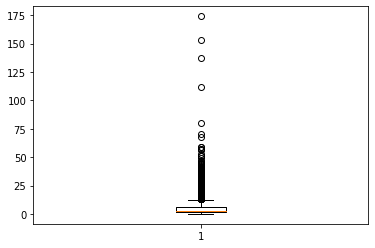

In [11]:
plt.boxplot(data["TIEMPO_ESPERA"])

In [12]:
data = data[data["TIEMPO_ESPERA"] <= time_summary["Q3"] + 1.5*time_summary["IQR"]]

### Normalización de datos numéroicos
Se normalizarán las variables de `EDAD` y `TIEMPO_ESPERA`

In [13]:
data["EDAD"].describe()

count    2.163626e+06
mean     4.355414e+01
std      1.700503e+01
min      0.000000e+00
25%      3.000000e+01
50%      4.200000e+01
75%      5.500000e+01
max      1.210000e+02
Name: EDAD, dtype: float64

In [14]:
scaled = preprocessing.MinMaxScaler()
scaled_edad = scaled.fit_transform(data["EDAD"].values.reshape(-1,1))
data["EDAD"] = scaled_edad

In [15]:
data["EDAD"].describe()

count    2.163626e+06
mean     3.599515e-01
std      1.405374e-01
min      0.000000e+00
25%      2.479339e-01
50%      3.471074e-01
75%      4.545455e-01
max      1.000000e+00
Name: EDAD, dtype: float64

In [16]:
data["TIEMPO_ESPERA"].describe()

count    2.163626e+06
mean     3.780447e+00
std      2.834329e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      1.200000e+01
Name: TIEMPO_ESPERA, dtype: float64

In [17]:
scaled = preprocessing.MinMaxScaler()
scaled_time = scaled.fit_transform(data["TIEMPO_ESPERA"].values.reshape(-1,1))
data["TIEMPO_ESPERA"] = scaled_time

In [18]:
data["TIEMPO_ESPERA"].describe()

count    2.163626e+06
mean     3.150373e-01
std      2.361941e-01
min      0.000000e+00
25%      1.666667e-01
50%      2.500000e-01
75%      5.000000e-01
max      1.000000e+00
Name: TIEMPO_ESPERA, dtype: float64

**Formula Edad Normalizada:**

$\large{E_N=\frac{E}{121}}$
******
**Formula Tiempo de espera Normalizado:**

$\large{T_N=\frac{T}{12}}$

## Modelo para condiciones iniciales del paciente


### Selección de las varianbles

In [19]:
X_before = data[before_columns].copy()
Y_deceased = data["FALLECIDO"].copy()
len(before_columns)

46

In [20]:
data.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO', 'SEXO',
       'SECTOR_ATENDIDO', 'ESTADO', 'ENFERMEDAD_GRAVE', 'FALLECIDO',
       'SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL',
       'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL',
       'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR',
       'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'E

Nos quedaremos con la mitad de las variables 

Se utiliza el solver sag porque es más rápido para datasets grandes (en variables y tamaño de la muestra)

* [Referencia 1](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions)
* [Referencia 2](https://rubialesalberto.medium.com/regresi%C3%B3n-log%C3%ADstica-con-sklearn-4384c707075d)

In [21]:
n = 15
lr = linear_model.LogisticRegression(solver="saga")
rfe = RFE(lr,n, step= 7)
rfe = rfe.fit(X_before,Y_deceased)

In [22]:
var_included = list(zip(before_columns, rfe.support_, rfe.ranking_))
var_included.sort(key = lambda x: x[2])
print (tabulate(var_included))

--------------  -  -
EDAD            1  1
DIABETES        1  1
INMUSUPR        1  1
OTRA_COM        1  1
OBESIDAD        1  1
RENAL_CRONICA   1  1
ESTADO_BC       1  1
ESTADO_BS       1  1
ESTADO_DF       1  1
ESTADO_HG       1  1
ESTADO_MC       1  1
ESTADO_QR       1  1
ESTADO_SL       1  1
ESTADO_TL       1  1
ESTADO_VZ       1  1
ESTADO_CH       0  2
ESTADO_PL       0  2
ESTADO_TC       0  2
HIPERTENSION    0  3
SEXO_HOMBRE     0  3
SEXO_MUJER      0  3
ESTADO_DG       0  3
ESTADO_NL       0  3
ESTADO_OC       0  3
ESTADO_QT       0  3
EPOC            0  4
ESTADO_CS       0  4
ESTADO_GT       0  4
ESTADO_MS       0  4
ESTADO_NT       0  4
ESTADO_SP       0  4
ESTADO_SR       0  4
ASMA            0  5
TABAQUISMO      0  5
ESTADO_AS       0  5
ESTADO_CC       0  5
ESTADO_GR       0  5
ESTADO_TS       0  5
ESTADO_ZS       0  5
EMBARAZO        0  6
CARDIOVASCULAR  0  6
ESTADO_CL       0  6
ESTADO_CM       0  6
ESTADO_JC       0  6
ESTADO_MN       0  6
ESTADO_YN       0  6
-------------

#### Variables escogidas

In [23]:
before_columns = ['EDAD', 'DIABETES', 'OTRA_COM', 'OBESIDAD', 'RENAL_CRONICA', 'ESTADO_BC', 'ESTADO_HG', 'ESTADO_MC', 'ESTADO_QR', 'ESTADO_VZ']

In [24]:
before_columns = [v[0] for v in var_included if v[1] == True]
before_columns

['EDAD',
 'DIABETES',
 'INMUSUPR',
 'OTRA_COM',
 'OBESIDAD',
 'RENAL_CRONICA',
 'ESTADO_BC',
 'ESTADO_BS',
 'ESTADO_DF',
 'ESTADO_HG',
 'ESTADO_MC',
 'ESTADO_QR',
 'ESTADO_SL',
 'ESTADO_TL',
 'ESTADO_VZ']

### Separación de datasets para entrenamiento y prueba



In [25]:
X_before = data[before_columns].copy()

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X_before, Y_deceased, test_size = 0.3, random_state = 442021)

### Creación de modelo de regresión logística

In [27]:
lm_before = linear_model.LogisticRegression(solver="saga")
lm_before.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
lm_before.score(X_test, Y_test)

0.9132783228160126

In [29]:
lm_before.score(X_before,Y_deceased)

0.9133560975880305

In [30]:
lm_before.intercept_

array([-6.78892276])

In [31]:
params = list(zip(X_before.columns, np.transpose(lm_before.coef_)))
params.append(("INTERCEPCION", lm_before.intercept_))
print(tabulate(params))

-------------  ---------
EDAD            9.46681
DIABETES        0.611828
INMUSUPR        0.429651
OTRA_COM        0.687625
OBESIDAD        0.484065
RENAL_CRONICA   1.25042
ESTADO_BC       0.610663
ESTADO_BS      -0.521227
ESTADO_DF      -0.465076
ESTADO_HG       0.673103
ESTADO_MC       0.828036
ESTADO_QR       0.489735
ESTADO_SL       0.424332
ESTADO_TL       0.48135
ESTADO_VZ       0.490169
INTERCEPCION   -6.78892
-------------  ---------


In [32]:
probs = lm_before.predict_proba(X_test)

In [33]:
ps = []
for p in probs:
  ps.append(p[1]) # La columna 0 del array contiene la prob de que el evento 0 ocurra, lo mismo para la 1
ps[0:5]

[0.015369707490688247,
 0.0026674757591545746,
 0.049488634094820017,
 0.005789383934630472,
 0.007309754685674008]

### Validación del modelo
No se usarán Matrices de Confusión ni curvas ROC por que el objetivo no es clasificar, si no obtener un modelo para predecir la probabilidad de muerte.

In [34]:
prediction = lm_before.predict(X_test)

In [35]:
metrics.accuracy_score(Y_test,prediction)

0.9132783228160126

#### Validación Cruzada

In [36]:
scores = cross_val_score(linear_model.LogisticRegression(solver="saga"), X_before, Y_deceased, scoring = "accuracy", cv = 10)
# Toma 11 minutos

In [37]:
scores 

array([0.91387622, 0.91457412, 0.91007705, 0.85032561, 0.90783544,
       0.77803506, 0.73868794, 0.90736359, 0.79061942, 0.91316405])

In [38]:
scores.mean()

0.8624558495838007

### Exportación de modelo


In [39]:
import pickle

In [40]:
mainpath = "/content/drive/MyDrive/Modelos"
filename = "LR_before.sav"

In [41]:
pickle.dump(lm_before, open(os.path.join(mainpath,filename),'wb'))

In [42]:
# Prueba de modelo guardad
loaded_model = pickle.load( open(os.path.join(mainpath,filename),'rb'))

In [43]:
loaded_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
params = list(zip(X_before.columns, np.transpose(loaded_model.coef_)))
params.append(("INTERCEPCION", loaded_model.intercept_))
print(tabulate(params))

-------------  ---------
EDAD            9.46681
DIABETES        0.611828
INMUSUPR        0.429651
OTRA_COM        0.687625
OBESIDAD        0.484065
RENAL_CRONICA   1.25042
ESTADO_BC       0.610663
ESTADO_BS      -0.521227
ESTADO_DF      -0.465076
ESTADO_HG       0.673103
ESTADO_MC       0.828036
ESTADO_QR       0.489735
ESTADO_SL       0.424332
ESTADO_TL       0.48135
ESTADO_VZ       0.490169
INTERCEPCION   -6.78892
-------------  ---------


## Modelo para condiciones post valoración médica.
Se agregan tres variables.
* `TIEMPO_ESPERA`: Mide el tiempo que pasó entre el inicio de los sintomas y el ingreso al sector médico
* `HOSPITALIZADO`: Indica si el paciente fue hospitalizado o su atención fue ambulatoria.
* `SEXTOR`: Variable categórica que indica el sector de salud que atendió al paciente.

### Selección de las variables

In [45]:
X_after = data[after_columns].copy()
Y_deceased = data["FALLECIDO"].copy()
len(after_columns)

61

In [46]:
X_after.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO',
       'SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL',
       'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL',
       'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR',
       'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'ESTADO_PL',
       'ESTADO_QR', 'ESTADO_QT', 'ESTADO_SL', 'ESTADO_SP', 'ESTADO

In [47]:
n = 20
lr = linear_model.LogisticRegression(solver = "saga")
rfe = RFE(lr,n, step = 7)
rfe = rfe.fit(X_after, Y_deceased)

In [48]:
var_included = list(zip(after_columns, rfe.support_, rfe.ranking_))
var_included.sort(key = lambda x: x[2])
print (tabulate(var_included))

------------------------------  -  -
EDAD                            1  1
EMBARAZO                        1  1
OBESIDAD                        1  1
RENAL_CRONICA                   1  1
HOSPITALIZADO                   1  1
SECTOR_ATENDIDO_CRUZ ROJA       1  1
SECTOR_ATENDIDO_DIF             1  1
SECTOR_ATENDIDO_ESTATAL         1  1
SECTOR_ATENDIDO_IMSS            1  1
SECTOR_ATENDIDO_IMSS-BIENESTAR  1  1
SECTOR_ATENDIDO_ISSSTE          1  1
SECTOR_ATENDIDO_MUNICIPAL       1  1
SECTOR_ATENDIDO_SSA             1  1
ESTADO_AS                       1  1
ESTADO_MS                       1  1
ESTADO_PL                       1  1
ESTADO_SP                       1  1
ESTADO_TC                       1  1
ESTADO_TL                       1  1
ESTADO_TS                       1  1
DIABETES                        0  2
INMUSUPR                        0  2
SECTOR_ATENDIDO_PRIVADA         0  2
ESTADO_BC                       0  2
ESTADO_HG                       0  2
ESTADO_NL                       0  2
S

In [49]:
after_columns = [v[0] for v in var_included if v[1] == True]
after_columns

['EDAD',
 'EMBARAZO',
 'OBESIDAD',
 'RENAL_CRONICA',
 'HOSPITALIZADO',
 'SECTOR_ATENDIDO_CRUZ ROJA',
 'SECTOR_ATENDIDO_DIF',
 'SECTOR_ATENDIDO_ESTATAL',
 'SECTOR_ATENDIDO_IMSS',
 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
 'SECTOR_ATENDIDO_ISSSTE',
 'SECTOR_ATENDIDO_MUNICIPAL',
 'SECTOR_ATENDIDO_SSA',
 'ESTADO_AS',
 'ESTADO_MS',
 'ESTADO_PL',
 'ESTADO_SP',
 'ESTADO_TC',
 'ESTADO_TL',
 'ESTADO_TS']

### Separación de datasets para entrenamiento y prueba

In [50]:
X_after = data[after_columns].copy()

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X_after, Y_deceased, test_size = 0.3, random_state = 442021)

### Creación de modelo de regresión logística

In [52]:
lm_after = linear_model.LogisticRegression(solver = "saga")
lm_after.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
lm_after.score(X_test, Y_test)

0.9284149452770657

In [56]:
lm_after.score(X_after,Y_deceased)

0.928243605872734

In [57]:
params = list(zip(X_after.columns, np.transpose(lm_after.coef_)))
params.append(("INTERCEPCION", lm_after.intercept_))
print(tabulate(params))

------------------------------  ---------
EDAD                             6.23781
EMBARAZO                        -1.15391
OBESIDAD                         0.319817
RENAL_CRONICA                    0.734213
HOSPITALIZADO                    3.60272
SECTOR_ATENDIDO_CRUZ ROJA        0.738303
SECTOR_ATENDIDO_DIF             -0.583726
SECTOR_ATENDIDO_ESTATAL          0.720548
SECTOR_ATENDIDO_IMSS             1.1013
SECTOR_ATENDIDO_IMSS-BIENESTAR   0.540379
SECTOR_ATENDIDO_ISSSTE           0.6204
SECTOR_ATENDIDO_MUNICIPAL       -1.33521
SECTOR_ATENDIDO_SSA              0.56524
ESTADO_AS                       -0.292282
ESTADO_MS                       -0.284152
ESTADO_PL                        0.330048
ESTADO_SP                        0.314383
ESTADO_TC                        0.304655
ESTADO_TL                        0.355657
ESTADO_TS                        0.316458
INTERCEPCION                    -7.83511
------------------------------  ---------


### Validación del modelo
No se usarán Matrices de Confusión ni curvas ROC por que el objetivo no es clasificar, si no obtener un modelo para predecir la probabilidad de muerte.

In [58]:
prediction = lm_after.predict(X_test)

In [59]:
metrics.accuracy_score(Y_test,prediction)

0.9284149452770657

#### Validación Cruzada

In [60]:
scores = cross_val_score(lm_after, X_after, Y_deceased, scoring = "accuracy", cv = 10)
# Toma 11 minutos

In [61]:
scores

array([0.93946747, 0.94848934, 0.92358675, 0.85337142, 0.66421708,
       0.70208862, 0.9146523 , 0.91401448, 0.82086965, 0.92380825])

In [62]:
scores.mean()

0.860456535241549

### Exportación de modelo

In [63]:
mainpath = "/content/drive/MyDrive/Modelos"
filename = "LR_after.sav"

In [64]:
pickle.dump(lm_after, open(os.path.join(mainpath,filename),'wb'))

In [65]:
# Prueba de modelo guardad
loaded_model = pickle.load( open(os.path.join(mainpath,filename),'rb'))

In [66]:
loaded_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
params = list(zip(X_after.columns, np.transpose(loaded_model.coef_)))
params.append(("INTERCEPCION", loaded_model.intercept_))
print(tabulate(params))

------------------------------  ---------
EDAD                             6.23781
EMBARAZO                        -1.15391
OBESIDAD                         0.319817
RENAL_CRONICA                    0.734213
HOSPITALIZADO                    3.60272
SECTOR_ATENDIDO_CRUZ ROJA        0.738303
SECTOR_ATENDIDO_DIF             -0.583726
SECTOR_ATENDIDO_ESTATAL          0.720548
SECTOR_ATENDIDO_IMSS             1.1013
SECTOR_ATENDIDO_IMSS-BIENESTAR   0.540379
SECTOR_ATENDIDO_ISSSTE           0.6204
SECTOR_ATENDIDO_MUNICIPAL       -1.33521
SECTOR_ATENDIDO_SSA              0.56524
ESTADO_AS                       -0.292282
ESTADO_MS                       -0.284152
ESTADO_PL                        0.330048
ESTADO_SP                        0.314383
ESTADO_TC                        0.304655
ESTADO_TL                        0.355657
ESTADO_TS                        0.316458
INTERCEPCION                    -7.83511
------------------------------  ---------
